In [1]:
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import sys
import matplotlib.pyplot as plt
from prepare_individuals import prepare, germanBats
import torch

classes = germanBats

In [2]:
prepared_hf = h5py.File('prepared.h5', 'r')

In [3]:
sample_rate = 22050                          # recordings are in 96 kHz, 24 bit depth, 1:10 TE (mic sr 960 kHz)
n_fft = 512                                  # 23 ms * 22050 Hz
frame_rate = int(sample_rate / (n_fft // 4)) # 22050 / 128 ~ 172

patch_len = 44                               # 88 bei 44100, 44 bei 22050 = 250ms ~ 25ms

In [4]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../datasets/prepared.h5", classes, patch_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.82it/s]


In [5]:
print("Total calls:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total calls: 54280
(31872, 44, 257) (31872,)


In [6]:
# with ml: 26,164
# without ml: 45,309

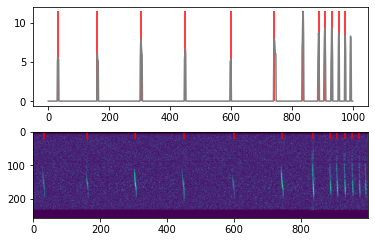

In [37]:
fig, axs = plt.subplots(2)
prepared_set = prepared_hf.require_group("train")
S_db = np.asarray(prepared_set.get("Myotis daubentonii"))
new_size = (int(S_db.shape[1] * 1.0), int(S_db.shape[0] * 1.0))
S_db = cv2.resize(S_db, dsize=new_size, interpolation=cv2.INTER_NEAREST)

ix = 4000
spec = S_db[ix:ix+1000]
individuals = []
env = np.mean(spec, axis=1)
env[env < 5] = 0
peaks = librosa.util.peak_pick(env, pre_max=5, post_max=5, pre_avg=4, post_avg=4, delta=0.4, wait=20)
axs[0].plot(env, color="grey")
axs[0].vlines(peaks, 0, env.max(), color='r')

# REMOVE LATER
axs[1].imshow(np.rot90(spec))
axs[1].vlines(peaks, 0, 20, color='r')

In [9]:
def plot_patch(patch, y):
    plt.figure(figsize = (5, 10))
    spec = np.rot90(patch)
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    plt.title(list(classes)[y])

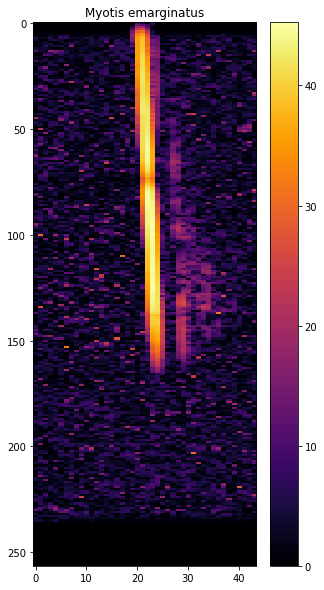

In [10]:
i = 0
plot_patch(X_train[i], Y_train[i])